## Exercise 3: EEG Feature Extraction
**Objective:**  Extract EEG-specific features relevant for data analysis, such as band power in EEG frequency bands (delta, theta, alpha, beta), signal variability, and complexity measures. 
- **Libraries:** `numpy`, `scipy`, `pandas`, `matplotlib` 
- **Tasks:**
  - Calculate descriptive statistics for each EEG channel, including mean, standard deviation, and peak-to-peak amplitude.
  - Compute band power for standard EEG frequency bands: delta (0.5-4 Hz), theta (4-8 Hz), alpha (8-12 Hz), beta (12-30 Hz).
  - Extract Hjorth parameters (activity, mobility, complexity) as features for each EEG channel.
  - Store all extracted features in a pandas DataFrame.
  - Visualize features (e.g., alpha band power) across all channels to observe patterns.
- **Expected Output:** A table with the extracted features for each EEG channel. Each row should represent a channel, and columns should include descriptive statistics, band power features, and Hjorth parameters.

In [300]:
import numpy as np 
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd 

import mne
from mne.datasets import eegbci
import seaborn as sns
from scipy.integrate import simps


### Load Data

In [301]:
path = mne.datasets.eegbci.load_data(1, 2)
path[0]
raw = mne.io.read_raw_edf(path[0], preload=True)

Extracting EDF parameters from C:\Users\USER\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


In [302]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>

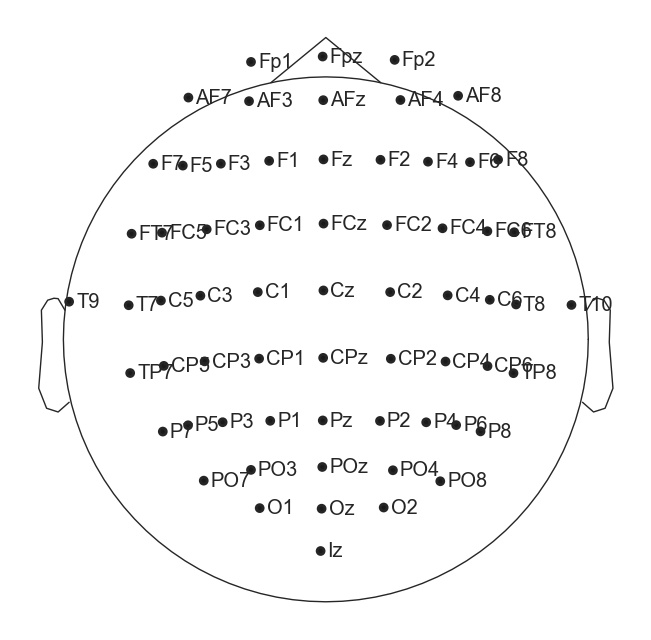

In [303]:
# set channels names 
eegbci.standardize(raw)

# set montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
raw.plot_sensors(kind='topomap', show_names=True);

### Prepropcessing

In [304]:
clean = raw.copy()
clean.notch_filter(60)
clean.filter(l_freq=1.0, h_freq=50.0) 

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawEDF | S001R02.edf, 64 x 9760 (61.0 s), ~4.8 MB, data loaded>

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 0.3s.


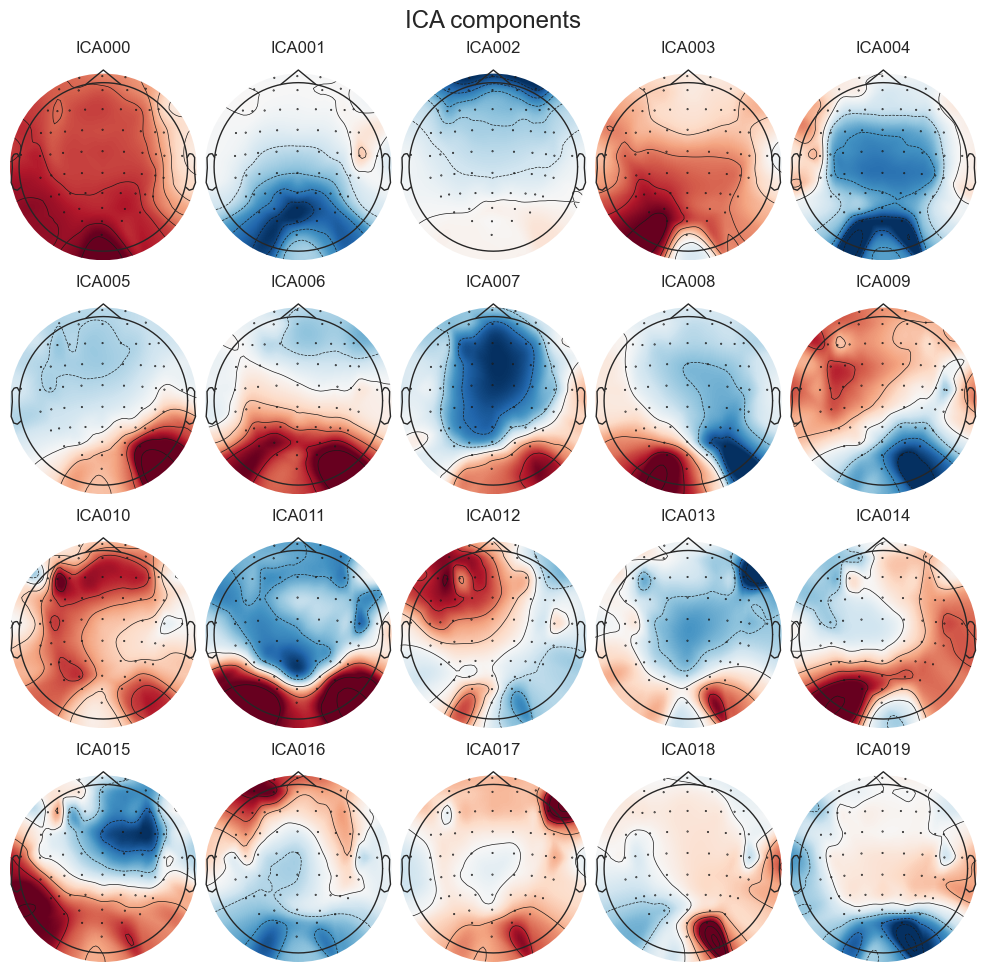

In [305]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter="auto")
ica.fit(clean)
ica.plot_components(); 

Creating RawArray with float64 data, n_channels=20, n_times=9760
    Range : 0 ... 9759 =      0.000 ...    60.994 secs
Ready.


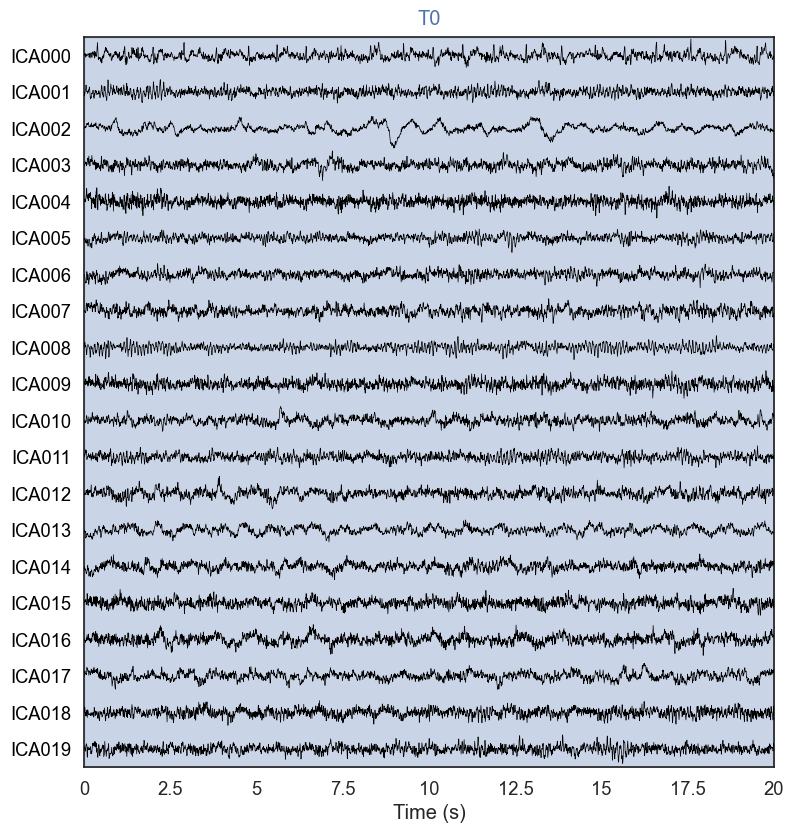

In [306]:
ica.plot_sources(clean, show_scrollbars=False); 

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


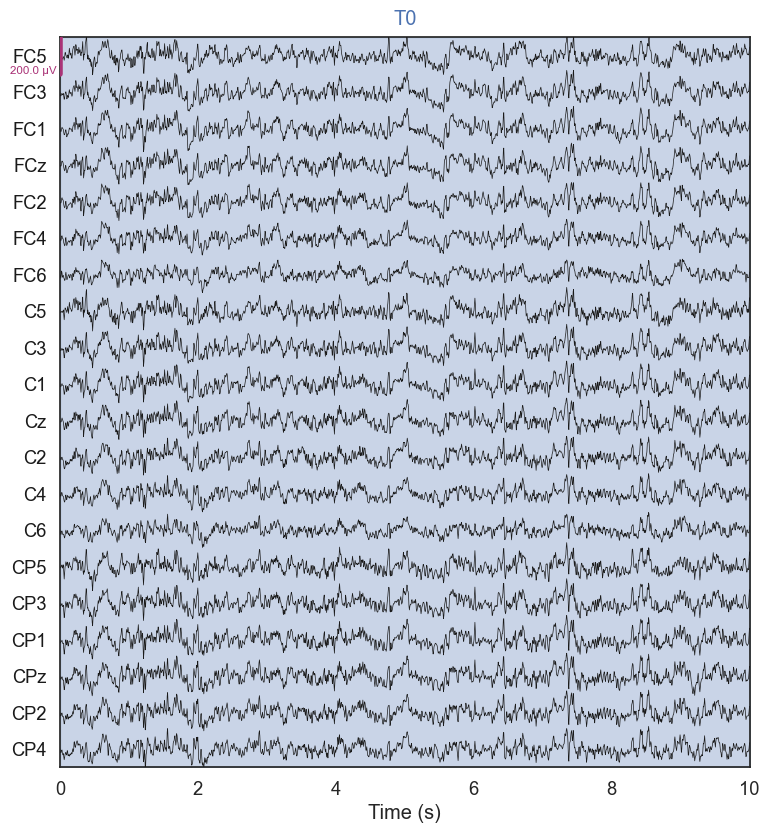

In [307]:
ica.exclude = [1, 5, 15] 
ica.apply(clean)
clean.plot(scalings=dict(eeg=100e-6),  show_scrollbars=False);

### Descriptive statistics 
mean, standard deviation, and peak-to-peak amplitude

In [308]:
features = pd.DataFrame(index=raw.info['ch_names'])
data = clean.get_data()

# calculate statistics 
features['mean'] = np.mean(data**2, axis=1) 
features['std'] = np.std(data**2, axis=1) 
features.head()

,mean,std
FC5,1.351241e-09,1.972234e-09
FC3,1.626112e-09,2.420558e-09
FC1,1.743687e-09,2.607679e-09
FCz,1.736000e-09,2.609031e-09
FC2,1.603494e-09,2.400201e-09


In [309]:
# plot # TODO 

In [310]:
# peak to peak amplitude 

sfreq = clean.info['sfreq'] 
time_window = int(sfreq * 1)
step_size = time_window // 5

n_channels, n_samples = data.shape
n_windows = ((n_samples - time_window) // step_size) + 1
data_ptp = np.zeros((n_channels, n_windows))

for i in range(n_windows):
    start_idx = i * step_size 
    end_idx = start_idx + time_window
    
    # compute peak-to-peak amplitude for each channel in this window
    data_ptp[:, i] = np.ptp(data[:, start_idx:end_idx], axis=1)

features['ptp'] = data_ptp.mean(1)


### Band power (spectral measures)

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


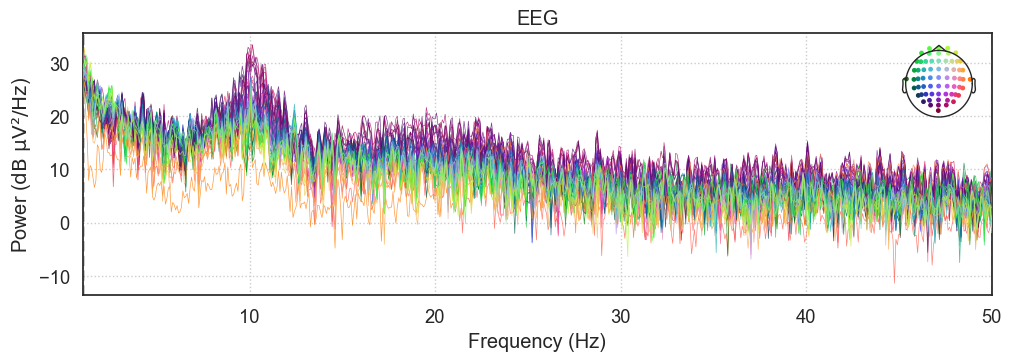

In [311]:
clean.compute_psd(fmin=1.0, fmax=50.0).plot();

In [312]:
band_powers = {'delta': [0.5, 4], 
               'theta': [4, 8], 
               'alpha': [8, 12], 
               'beta': [12, 30], 
               'gamma': [30, 50]}

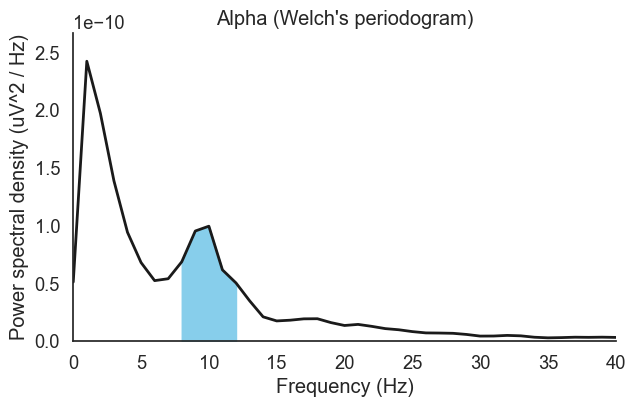

In [318]:
# plot alpha example 

freqs, psd = signal.welch(data[1,:], sfreq, nperseg=time_window)

[low, high] = band_powers['alpha']
idx_alpha = np.logical_and(freqs >= low, freqs <= high)

plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_alpha, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 40])
plt.ylim([0, psd.max() * 1.1])
plt.title("Alpha (Welch's periodogram)")
sns.despine()
 

In [314]:
# compute absolute power

for i, ch in enumerate(features.index):
    freqs, psd = signal.welch(data[i,:], sfreq, nperseg=time_window)
    freq_res = freqs[1] - freqs[0]
    for band in band_powers:
        [low, high] = band_powers[band]
        idx_band  = np.logical_and(freqs >= low, freqs <= high)
        bp = simps(psd[idx_band], dx=freq_res)
        features.loc[ch, band] = bp

In [319]:
features.head()

,mean,std,ptp,delta,theta,alpha,beta,gamma
FC5,1.351241e-09,1.972234e-09,0.000177,4.039739e-10,2.124801e-10,2.388396e-10,2.354931e-10,6.952541e-11
FC3,1.626112e-09,2.420558e-09,0.000193,5.058940e-10,2.524705e-10,3.159529e-10,2.715682e-10,6.405674e-11
FC1,1.743687e-09,2.607679e-09,0.000199,5.477489e-10,2.748350e-10,3.362440e-10,2.705223e-10,6.403358e-11
FCz,1.736000e-09,2.609031e-09,0.000199,5.402360e-10,2.769285e-10,3.276790e-10,2.561500e-10,6.845718e-11
FC2,1.603494e-09,2.400201e-09,0.000190,4.997111e-10,2.425489e-10,3.103103e-10,2.318371e-10,6.607057e-11


### Complexity (Hjorth)
activity, mobility, complexity

### References 

* [get clean EEG sample](https://g0rella.github.io/gorella_mwn/preprocessing_eeg.html)
* [mean power](https://mne.discourse.group/t/questions-for-calculate-power/7767)
* [peak to peak amplitude in EEG](https://www.researchgate.net/figure/Peak-to-peak-amplitude-of-slow-waves-according-to-different-EEG-montages-This-N3-epoch_fig2_372138747)
* [numpy ptp](https://numpy.org/doc/stable/reference/generated/numpy.ptp.html)
* [bandpower](https://raphaelvallat.com/bandpower.html)

and previous exercises. 
